# Acelerando o Produto Cartesiano de Grafos

## Execução do experimento

In [ ]:
!git clone https://github.com/DanteCampos/Graduation/
!mv Graduation/'Computação Paralela'/Trabalho/* .
!rm -r Graduation
!ls

Cloning into 'Graduation'...
remote: Enumerating objects: 1971, done.
remote: Counting objects: 100% (531/531), done.
remote: Compressing objects: 100% (371/371), done.
remote: Total 1971 (delta 169), reused 495 (delta 146), pack-reused 1440
Receiving objects: 100% (1971/1971), 70.60 MiB | 17.87 MiB/s, done.
Resolving deltas: 100% (432/432), done.
generate_graphs.py	 prodCartBitmap.c  test_upper_triangle_bitmap_32.c
generate_graphs_test.py  prodCart.cu	   test_upper_triangle_bitmap.c
how-to-run.md		 sample_data	   test_upper_triangle.c
prodCartArray.c		 test_bitmap.c


In [ ]:
# To re-run the experiment
!rm -r 0.25 0.5 0.75 CUDAresult CUDAtime SEQresult SEQtime

rm: cannot remove 'CUDAresult': No such file or directory
rm: cannot remove 'CUDAtime': No such file or directory
rm: cannot remove 'SEQresult': No such file or directory
rm: cannot remove 'SEQtime': No such file or directory


In [ ]:
# Generating graphs
# n vertices
# p probability to connect each pair of vertices
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx import write_edgelist
import os
from datetime import datetime as dt

print("Generating...\n")
now = dt.now()
for p in [0.25, 0.5, 0.75]:
  if not os.path.exists(str(p)):
    os.makedirs(str(p))
  for n in range(5, 651, 5): # Maximum number of vertices must be 650 to avoid memory leak
    g = erdos_renyi_graph(n, p)
    write_edgelist(g, str(p)+"/"+str(n)+"."+str(len(g.edges))+".graph", data=False)
after = dt.now()

print("Generating time:")
print (after-now)

Generating...

Generating time:
0:00:32.703873


In [ ]:
# Compiling and executing the sequential vector array algorithm
!gcc prodCartArray.c -O0 -o prodCartArrayC # -O0 to disable optimizations that may use SIMD extensions (not sequential)
!./prodCartArrayC

Starting ./0.25/ x ./0.5/ batch

Calculating 180.4045 x 85.1787... Finished!
Processing time (ms): 15.084000
Time saved as ./SEQtime/processing-0.25x0.5-180.4045x85.1787.time

Calculating 225.6175 x 215.11495... Finished!
Processing time (ms): 67.023000
Time saved as ./SEQtime/processing-0.25x0.5-225.6175x215.11495.time

Calculating 260.8452 x 385.37132... Finished!
Processing time (ms): 200.672000
Time saved as ./SEQtime/processing-0.25x0.5-260.8452x385.37132.time

Calculating 505.31635 x 335.27769... Finished!
Processing time (ms): 271.684000
Time saved as ./SEQtime/processing-0.25x0.5-505.31635x335.27769.time

Calculating 340.14470 x 400.39956... Finished!
Processing time (ms): 201.614000
Time saved as ./SEQtime/processing-0.25x0.5-340.14470x400.39956.time

Calculating 575.41429 x 35.313... Finished!
Processing time (ms): 18.093000
Time saved as ./SEQtime/processing-0.25x0.5-575.41429x35.313.time

Calculating 490.29982 x 350.30457... Finished!
Processing time (ms): 264.393000
Time s

In [ ]:
!nvcc prodCart.cu -arch=native -o prodCartCUDA
!./prodCartCUDA 128 1 # n_threads_per_block n_blocks_per_SM

prodCart.cu(248): warning #177-D: variable "result_file_name" was declared but never referenced

prodCart.cu(262): warning #550-D: variable "len_P_ints" was set but never used

Starting ./0.25/ x ./0.5/ batch

Calculating 180.4045 x 85.1787... Finished!
Host to device memory transfer time (ms): 0.142000
Processing time (ms): 0.231000
Device to host memory transfer time (ms): 1.687000
Host to device memory transfer time saved as ./CUDAtime/host_to_device-0.25x0.5-180.4045x85.1787.time
Processing time saved as ./CUDAtime/processing-0.25x0.5-180.4045x85.1787.time
Device to host memory transfer time saved as ./CUDAtime/device_to_host-0.25x0.5-180.4045x85.1787.time

Calculating 225.6175 x 215.11495... Finished!
Host to device memory transfer time (ms): 0.722000
Processing time (ms): 1.276000
Device to host memory transfer time (ms): 14.492000
Host to device memory transfer time saved as ./CUDAtime/host_to_device-0.25x0.5-225.6175x215.11495.time
Processing time saved as ./CUDAtime/processing

## Analisando os resultados

In [ ]:
import os
class Result:
  def __init__(self,  filename):
    split = filename.split("-")
    self.densities = split[0]
    #densities = split[0].split("x")
    #self.G_den = densities[0]
    #self.H_den = densities[1]
    graphs = split[1].split("x")
    G = graphs[0].split(".")
    H = graphs[1].split(".")
    self.G_vertx = int(G[0])
    self.H_vertx = int(H[0])
    self.G_edges = int(G[1])
    self.H_edges = int(H[1])
    self.sum_vertx = self.G_vertx+self.H_vertx
    self.sum_edges = self.G_edges+self.H_edges
    f = open("SEQtime/processing-"+filename, "r")
    self.seq_proc_time = float(f.read())
    f.close()
    f = open("CUDAtime/processing-"+filename, "r")
    self.cuda_proc_time = float(f.read())
    f.close()
    f = open("CUDAtime/host_to_device-"+filename, "r")
    self.cuda_host2dev_time = float(f.read())
    f.close()
    f = open("CUDAtime/device_to_host-"+filename, "r")
    self.cuda_dev2host_time = float(f.read())
    f.close()
    self.cuda_total_time = self.cuda_proc_time+self.cuda_host2dev_time+self.cuda_dev2host_time
    self.processing_speedup = self.seq_proc_time/self.cuda_proc_time
    self.actual_speedup = self.seq_proc_time/self.cuda_total_time
    size = (self.G_vertx*self.H_vertx)*(self.G_vertx*self.H_vertx-1)
    self.bitmap_size = float(size)/16.0
    self.dev2host_per_byte = self.cuda_dev2host_time/self.bitmap_size

In [ ]:
import pandas as pd

results = pd.DataFrame()

# Reading sequential algorithm results
for filename in os.listdir("SEQtime/"):
  result = Result(filename.split("processing-")[1]) # Removing the type of process time
  result_dataframe = pd.DataFrame([vars(result)])
  results = pd.concat([results, result_dataframe], ignore_index=True)


In [ ]:
# Getting results sorted by the processing speedup
results.sort_values("processing_speedup")

,densities,G_vertx,H_vertx,G_edges,H_edges,sum_vertx,sum_edges,seq_proc_time,cuda_proc_time,cuda_host2dev_time,cuda_dev2host_time,cuda_total_time,processing_speedup,actual_speedup,bitmap_size,dev2host_per_byte
389,0.25x0.5,35,5,156,6,40,162,0.007,0.030,0.022,0.016,0.068,0.233333,0.102941,1.903125e+03,8.407225e-06
350,0.75x0.25,15,30,84,89,45,173,0.038,0.029,0.036,0.017,0.082,1.310345,0.463415,1.262812e+04,1.346201e-06
266,0.25x0.5,25,25,82,164,50,246,0.048,0.031,0.034,0.030,0.095,1.548387,0.505263,2.437500e+04,1.230769e-06
9,0.25x0.5,5,100,4,2488,105,2492,0.094,0.032,0.055,0.017,0.104,2.937500,0.903846,1.559375e+04,1.090180e-06
243,0.75x0.25,75,10,2113,13,85,2126,0.123,0.031,0.048,0.017,0.096,3.967742,1.281250,3.510938e+04,4.842012e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.25x0.5,50,545,280,74220,595,74500,40.478,0.348,0.473,4.764,5.585,116.316092,7.247628,4.640845e+07,1.026537e-07
333,0.75x0.25,640,65,153298,470,705,153768,161.352,1.347,1.170,11.250,13.767,119.786192,11.720200,1.081574e+08,1.040151e-07
144,0.25x0.5,55,570,373,80997,625,81370,53.635,0.429,0.568,6.317,7.314,125.023310,7.333197,6.142445e+07,1.028418e-07
317,0.5x0.75,30,610,223,139508,640,139731,46.249,0.345,0.703,2.091,3.139,134.055072,14.733673,2.092948e+07,9.990692e-08


In [ ]:
# Getting cummulative metrics from the results
results.describe()

,G_vertx,H_vertx,G_edges,H_edges,sum_vertx,sum_edges,seq_proc_time,cuda_proc_time,cuda_host2dev_time,cuda_dev2host_time,cuda_total_time,processing_speedup,actual_speedup,bitmap_size,dev2host_per_byte
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,3.900000e+02,3.900000e+02
mean,327.500000,327.500000,35535.979487,35535.979487,655.000000,71071.958974,270.087572,9.184354,6.092528,112.491231,127.768113,39.928494,3.271470,1.335510e+09,1.286363e-07
std,187.874305,187.874305,37210.829441,37210.829441,273.490012,51836.194515,328.471010,13.176488,8.736799,157.933201,179.390686,20.923909,2.031169,1.981967e+09,4.324331e-07
min,5.000000,5.000000,4.000000,4.000000,40.000000,162.000000,0.007000,0.029000,0.022000,0.016000,0.068000,0.233333,0.102941,1.903125e+03,7.762541e-08
25%,165.000000,165.000000,5873.500000,5873.500000,455.000000,28970.000000,31.713750,0.478000,0.393500,5.667500,6.644750,26.811555,2.076732,5.085306e+07,8.691773e-08
50%,327.500000,327.500000,23160.000000,23160.000000,635.000000,60517.500000,141.651500,3.116500,2.069000,41.690500,47.275500,34.653172,2.753358,4.248702e+08,9.710801e-08
75%,490.000000,490.000000,51544.500000,51544.500000,850.000000,106458.500000,424.986500,11.626000,8.139000,157.275250,176.901500,47.223303,3.847317,1.804259e+09,1.043644e-07
max,650.000000,650.000000,158236.000000,158236.000000,1265.000000,229727.000000,1811.522000,66.693000,43.988000,779.662000,867.933000,136.772881,16.518887,9.994976e+09,8.407225e-06


In [ ]:
# Separating data frames to plot
times_by_vertx = results.drop(["G_vertx", "H_vertx", "G_edges", "H_edges", "sum_edges", "bitmap_size", "dev2host_per_byte"],axis=1)

df025x05 = times_by_vertx[(times_by_vertx["densities"] == "0.25x0.5")].drop(["densities"],axis=1)
df05x075 = times_by_vertx[(times_by_vertx["densities"] == "0.5x0.75")].drop(["densities"],axis=1)
df075x025 = times_by_vertx[(times_by_vertx["densities"] == "0.75x0.25")].drop(["densities"],axis=1)

cuda_proc_time_df025x05 = df025x05.drop(["seq_proc_time", "cuda_dev2host_time", "cuda_host2dev_time", "processing_speedup", "actual_speedup", "cuda_total_time"], axis=1).rename(columns={"cuda_proc_time":"0.25x0.5"}).sort_values("sum_vertx")
cuda_proc_time_df05x075 = df05x075.drop(["seq_proc_time", "cuda_dev2host_time", "cuda_host2dev_time", "processing_speedup", "actual_speedup", "cuda_total_time"], axis=1).rename(columns={"cuda_proc_time":"0.5x0.75"}).sort_values("sum_vertx")
cuda_proc_time_df075x025 = df075x025.drop(["seq_proc_time", "cuda_dev2host_time", "cuda_host2dev_time", "processing_speedup", "actual_speedup", "cuda_total_time"], axis=1).rename(columns={"cuda_proc_time":"0.75x0.25"}).sort_values("sum_vertx")

seq_proc_time_df025x05 = df025x05.drop(["cuda_proc_time", "cuda_dev2host_time", "cuda_host2dev_time", "processing_speedup", "actual_speedup", "cuda_total_time"], axis=1).rename(columns={"seq_proc_time":"0.25x0.5"}).sort_values("sum_vertx")
seq_proc_time_df05x075 = df05x075.drop(["cuda_proc_time", "cuda_dev2host_time", "cuda_host2dev_time", "processing_speedup", "actual_speedup", "cuda_total_time"], axis=1).rename(columns={"seq_proc_time":"0.5x0.75"}).sort_values("sum_vertx")
seq_proc_time_df075x025 = df075x025.drop(["cuda_proc_time", "cuda_dev2host_time", "cuda_host2dev_time", "processing_speedup", "actual_speedup", "cuda_total_time"], axis=1).rename(columns={"seq_proc_time":"0.75x0.25"}).sort_values("sum_vertx")

cuda_host2dev_time_df025x05 = df025x05.drop(["cuda_proc_time", "cuda_dev2host_time", "seq_proc_time", "processing_speedup", "actual_speedup", "cuda_total_time"], axis=1).rename(columns={"cuda_host2dev_time":"0.25x0.5"}).sort_values("sum_vertx")
cuda_host2dev_time_df05x075 = df05x075.drop(["cuda_proc_time", "cuda_dev2host_time", "seq_proc_time", "processing_speedup", "actual_speedup", "cuda_total_time"], axis=1).rename(columns={"cuda_host2dev_time":"0.5x0.75"}).sort_values("sum_vertx")
cuda_host2dev_time_df075x025 = df075x025.drop(["cuda_proc_time", "cuda_dev2host_time", "seq_proc_time", "processing_speedup", "actual_speedup", "cuda_total_time"], axis=1).rename(columns={"cuda_host2dev_time":"0.75x0.25"}).sort_values("sum_vertx")

cuda_dev2host_time = times_by_vertx.drop(["densities", "seq_proc_time", "cuda_proc_time", "processing_speedup", "actual_speedup", "cuda_host2dev_time", "cuda_total_time"], axis=1).sort_values("sum_vertx")

processing_speedup_df025x05 = df025x05.drop(["cuda_proc_time", "cuda_dev2host_time", "seq_proc_time", "cuda_host2dev_time", "actual_speedup", "cuda_total_time"], axis=1).rename(columns={"processing_speedup":"0.25x0.5"}).sort_values("sum_vertx")
processing_speedup_df05x075 = df05x075.drop(["cuda_proc_time", "cuda_dev2host_time", "seq_proc_time", "cuda_host2dev_time", "actual_speedup", "cuda_total_time"], axis=1).rename(columns={"processing_speedup":"0.5x0.75"}).sort_values("sum_vertx")
processing_speedup_df075x025 = df075x025.drop(["cuda_proc_time", "cuda_dev2host_time", "seq_proc_time", "cuda_host2dev_time", "actual_speedup", "cuda_total_time"], axis=1).rename(columns={"processing_speedup":"0.75x0.25"}).sort_values("sum_vertx")

actual_speedup_df025x05 = df025x05.drop(["cuda_proc_time", "cuda_dev2host_time", "seq_proc_time", "cuda_host2dev_time", "processing_speedup", "cuda_total_time"], axis=1).rename(columns={"actual_speedup":"0.25x0.5"}).sort_values("sum_vertx")
actual_speedup_df05x075 = df05x075.drop(["cuda_proc_time", "cuda_dev2host_time", "seq_proc_time", "cuda_host2dev_time", "processing_speedup", "cuda_total_time"], axis=1).rename(columns={"actual_speedup":"0.5x0.75"}).sort_values("sum_vertx")
actual_speedup_df075x025 = df075x025.drop(["cuda_proc_time", "cuda_dev2host_time", "seq_proc_time", "cuda_host2dev_time", "processing_speedup", "cuda_total_time"], axis=1).rename(columns={"actual_speedup":"0.75x0.25"}).sort_values("sum_vertx")

df025x05 = df025x05.drop(["processing_speedup", "actual_speedup"],axis=1)
df05x075 = df05x075.drop([ "processing_speedup", "actual_speedup"],axis=1)
df075x025 = df075x025.drop(["processing_speedup", "actual_speedup"],axis=1)

In [ ]:
# Make directory to save files
import os
os.makedirs("figures")

FileExistsError: ignored

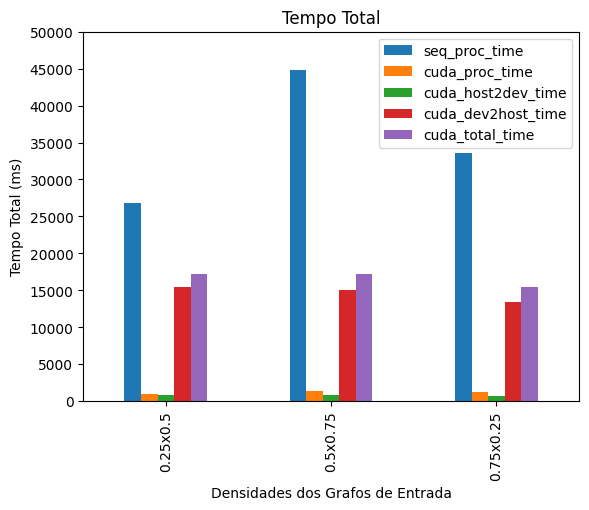

In [ ]:
plot = times_by_vertx.drop(["processing_speedup", "actual_speedup", "sum_vertx"],axis=1).groupby("densities").sum().plot(
    kind="bar",
    yticks=range(0,50001, 5000),
    xlabel="Densidades dos Grafos de Entrada",
    ylabel="Tempo Total (ms)",
    title="Tempo Total"
    )
plot.get_figure().savefig("figures/all_times_per_density.pdf", bbox_inches='tight')

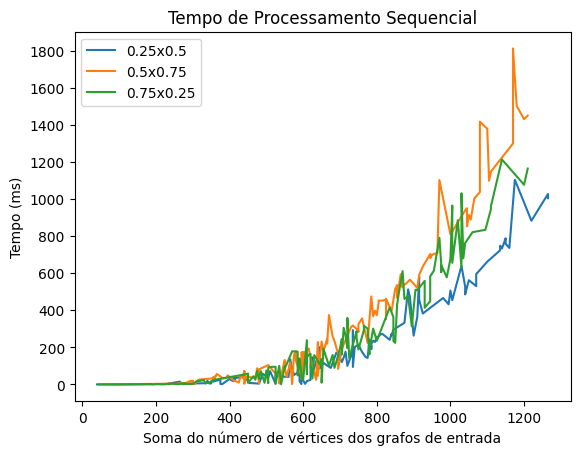

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = seq_proc_time_df025x05.plot(ax=ax, kind='line', x='sum_vertx', y='0.25x0.5')
ax = seq_proc_time_df05x075.plot(ax=ax, kind='line', x='sum_vertx', y='0.5x0.75')
ax = seq_proc_time_df075x025.plot(ax=ax, kind='line', x='sum_vertx', y='0.75x0.25')
ax.set_yticks(range(0, 1801, 200))
ax.set_xticks(range(0, 1301, 200))
ax.set_title("Tempo de Processamento Sequencial")
ax.set_xlabel("Soma do número de vértices dos grafos de entrada")
ax.set_ylabel('Tempo (ms)')

plt.savefig("figures/seq_proc_time_per_density.pdf", bbox_inches='tight')
plt.show()

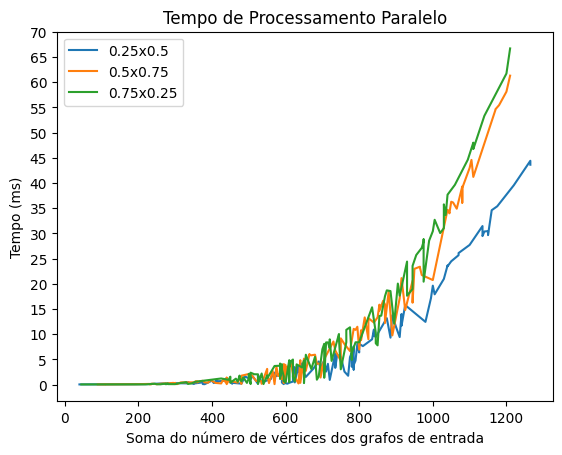

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = cuda_proc_time_df025x05.plot(ax=ax, kind='line', x='sum_vertx', y='0.25x0.5')
ax = cuda_proc_time_df05x075.plot(ax=ax, kind='line', x='sum_vertx', y='0.5x0.75')
ax = cuda_proc_time_df075x025.plot(ax=ax, kind='line', x='sum_vertx', y='0.75x0.25')
ax.set_yticks(range(0, 71, 5))
ax.set_xticks(range(0, 1301, 200))
ax.set_title("Tempo de Processamento Paralelo")
ax.set_xlabel("Soma do número de vértices dos grafos de entrada")
ax.set_ylabel('Tempo (ms)')

plt.savefig("figures/cuda_proc_time_per_density.pdf", bbox_inches='tight')
plt.show()

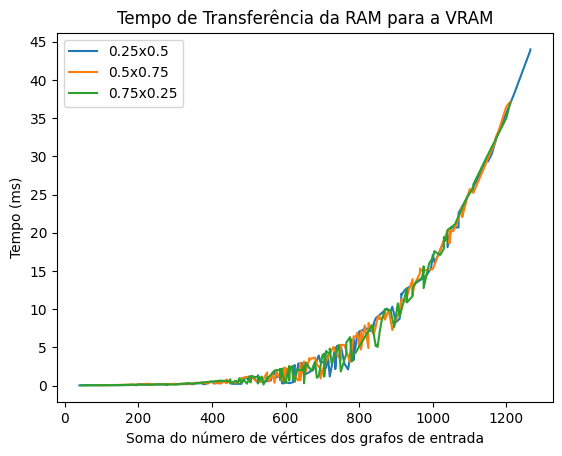

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = cuda_host2dev_time_df025x05.plot(ax=ax, kind='line', x='sum_vertx', y='0.25x0.5')
ax = cuda_host2dev_time_df05x075.plot(ax=ax, kind='line', x='sum_vertx', y='0.5x0.75')
ax = cuda_host2dev_time_df075x025.plot(ax=ax, kind='line', x='sum_vertx', y='0.75x0.25')
ax.set_yticks(range(0, 46, 5))
ax.set_xticks(range(0, 1301, 200))
ax.set_title("Tempo de Transferência da RAM para a VRAM")
ax.set_xlabel("Soma do número de vértices dos grafos de entrada")
ax.set_ylabel('Tempo (ms)')

plt.savefig("figures/cuda_host2dev_time_per_density.pdf", bbox_inches='tight')
plt.show()

<Axes: title={'center': 'Tempo de Transferência da VRAM para a RAM'}, xlabel='Soma do número de vértices dos grafos de entrada', ylabel='Tempo (ms)'>

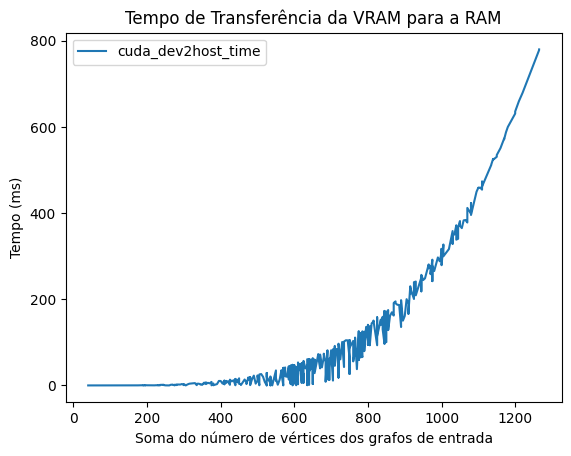

In [ ]:
plot = cuda_dev2host_time.plot(
        x="sum_vertx",
        kind="line",
        title="Tempo de Transferência da VRAM para a RAM",
        xlabel="Soma do número de vértices dos grafos de entrada",
        ylabel="Tempo (ms)",
        xticks=range(0,1301,200),
        yticks=range(0,801,200)
        )
plot.get_figure().savefig("figures/cuda_dev2host_time.pdf", bbox_inches='tight')
plot

<Axes: title={'center': 'Tempos para Produtos 0.25x0.5'}, xlabel='Soma do número de vértices dos grafos de entrada', ylabel='Tempo (ms)'>

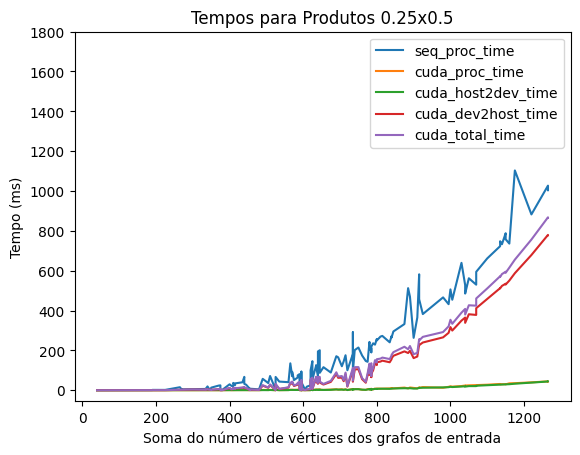

In [ ]:
plot = df025x05.sort_values(
        "sum_vertx"
        ).plot(
        x="sum_vertx",
        kind="line",
        title="Tempos para Produtos 0.25x0.5",
        xlabel="Soma do número de vértices dos grafos de entrada",
        ylabel="Tempo (ms)",
        xticks=range(0,1301,200),
        yticks=range(0,1801,200)
        )
plot.get_figure().savefig("figures/times_025x05.pdf", bbox_inches='tight')
plot

<Axes: title={'center': 'Tempos para Produtos 0.5x0.75'}, xlabel='Soma do número de vértices dos grafos de entrada', ylabel='Tempo (ms)'>

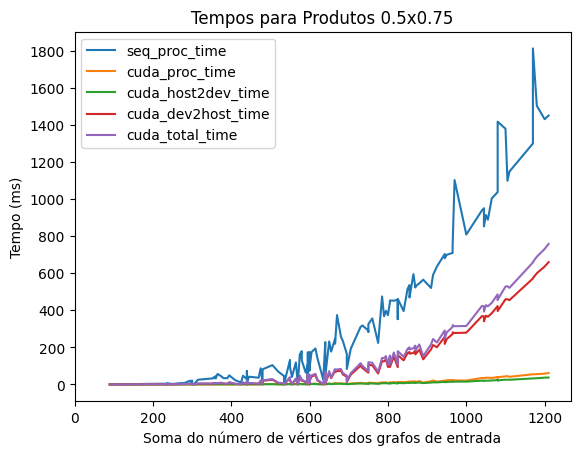

In [ ]:
plot = df05x075.sort_values(
        "sum_vertx"
        ).plot(
        x="sum_vertx",
        kind="line",
        title="Tempos para Produtos 0.5x0.75",
        xlabel="Soma do número de vértices dos grafos de entrada",
        ylabel="Tempo (ms)",
        xticks=range(0,1301,200),
        yticks=range(0,1801,200)
        )
plot.get_figure().savefig("figures/times_05x075.pdf", bbox_inches='tight')
plot

<Axes: title={'center': 'Tempos para Produtos 0.75x0.25'}, xlabel='Soma do número de vértices dos grafos de entrada', ylabel='Tempo (ms)'>

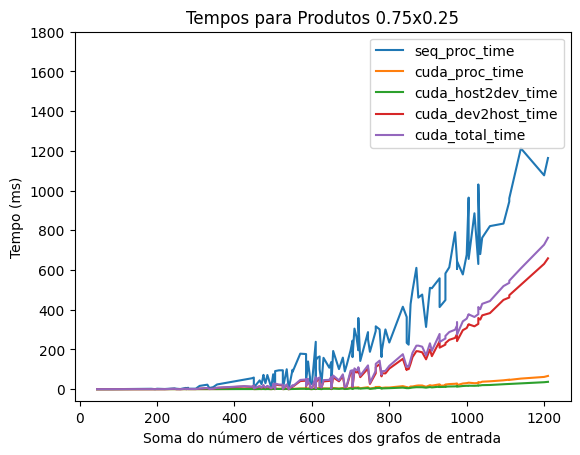

In [ ]:
plot = df075x025.sort_values(
        "sum_vertx"
        ).plot(
        x="sum_vertx",
        kind="line",
        title="Tempos para Produtos 0.75x0.25",
        xlabel="Soma do número de vértices dos grafos de entrada",
        ylabel="Tempo (ms)",
        xticks=range(0,1301,200),
        yticks=range(0,1801,200)
        )
plot.get_figure().savefig("figures/times_075x025.pdf", bbox_inches='tight')
plot

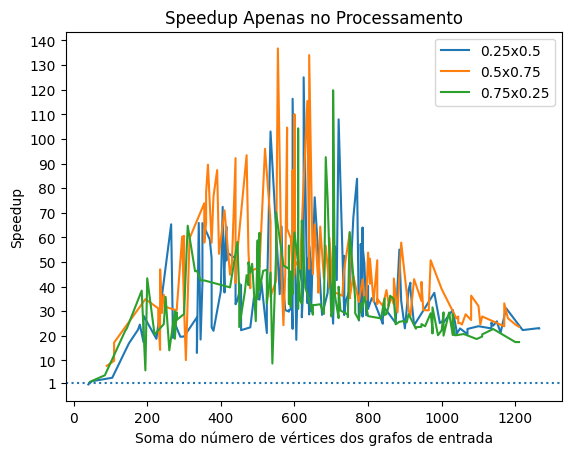

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain

fig, ax = plt.subplots()
ax = processing_speedup_df025x05.plot(ax=ax, kind='line', x='sum_vertx', y='0.25x0.5')
ax = processing_speedup_df05x075.plot(ax=ax, kind='line', x='sum_vertx', y='0.5x0.75')
ax = processing_speedup_df075x025.plot(ax=ax, kind='line', x='sum_vertx', y='0.75x0.25')
ax.set_xticks(range(0,1300,200))
ax.set_yticks(list(chain([1], range(10,141,10))))
ax.set_title("Speedup Apenas no Processamento")
ax.set_xlabel("Soma do número de vértices dos grafos de entrada")
ax.set_ylabel('Speedup')
ax = plt.axhline(y = 1, linestyle = 'dotted', label="No Speedup")

plt.savefig("figures/proc_speedup_per_density.pdf", bbox_inches='tight')
plt.show()

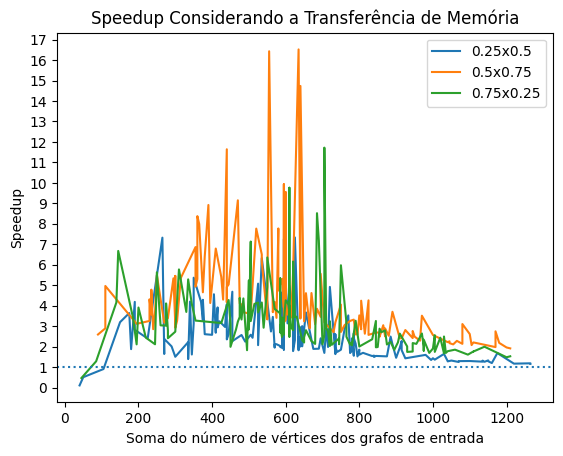

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = actual_speedup_df025x05.plot(ax=ax, kind='line', x='sum_vertx', y='0.25x0.5')
ax = actual_speedup_df05x075.plot(ax=ax, kind='line', x='sum_vertx', y='0.5x0.75')
ax = actual_speedup_df075x025.plot(ax=ax, kind='line', x='sum_vertx', y='0.75x0.25')
ax.set_xticks(range(0,1300,200))
ax.set_yticks(range(0,18,1))
ax.set_title("Speedup Considerando a Transferência de Memória")
ax.set_xlabel("Soma do número de vértices dos grafos de entrada")
ax.set_ylabel('Speedup')
ax = plt.axhline(y = 1, linestyle = 'dotted', label="No Speedup")

plt.savefig("figures/actual_speedup_per_density.pdf", bbox_inches='tight')
plt.show()

In [ ]:
# Compressing figures in one file
!zip -r figures.zip figures/

updating: figures/ (stored 0%)
updating: figures/cuda_host2dev_time_per_density.pdf (deflated 25%)
updating: figures/seq_proc_time_per_density.pdf (deflated 25%)
updating: figures/cuda_dev2host_time.pdf (deflated 26%)
updating: figures/cuda_proc_time_per_density.pdf (deflated 25%)
updating: figures/actual_speedup_per_density.pdf (deflated 24%)
updating: figures/all_times_per_density.pdf (deflated 32%)
updating: figures/proc_speedup_per_density.pdf (deflated 23%)
updating: figures/times_05x075.pdf (deflated 24%)
updating: figures/times_075x025.pdf (deflated 24%)
updating: figures/times_025x05.pdf (deflated 24%)


In [ ]:
!nvcc prodCart.cu -o prodCartCUDA
!nvprof ./prodCartCUDA 128 1

prodCart.cu(248): warning #177-D: variable "result_file_name" was declared but never referenced

prodCart.cu(262): warning #550-D: variable "len_P_ints" was set but never used

==21356== NVPROF is profiling process 21356, command: ./prodCartCUDA 128 1
Starting ./0.25/ x ./0.5/ batch

Calculating 180.4045 x 85.1787... Finished!
Host to device memory transfer time (ms): 0.145000
Processing time (ms): 0.241000
Device to host memory transfer time (ms): 1.434000
Host to device memory transfer time saved as ./CUDAtime/host_to_device-0.25x0.5-180.4045x85.1787.time
Processing time saved as ./CUDAtime/processing-0.25x0.5-180.4045x85.1787.time
Device to host memory transfer time saved as ./CUDAtime/device_to_host-0.25x0.5-180.4045x85.1787.time

Calculating 225.6175 x 215.11495... Finished!
Host to device memory transfer time (ms): 0.731000
Processing time (ms): 1.280000
Device to host memory transfer time (ms): 14.160000
Host to device memory transfer time saved as ./CUDAtime/host_to_device-0.25